In [34]:
!pip install gurobipy pyyaml matplotlib numpy networkx

import gurobipy as gp
from gurobipy import GRB
import numpy as np
import yaml
import matplotlib.pyplot as plt
import networkx as nx
from collections import defaultdict
import time


In [35]:
params = {
    "WLSACCESSID": "1e335bee-25ff-4080-907f-c54625d209bb",
    "WLSSECRET": "ae1ce61d-790d-4250-a7a2-19add6761142",
    "LICENSEID": 2718097
}

env = gp.Env(params=params)
print("✅ Gurobi license activated!")


Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2718097
Academic license 2718097 - for non-commercial use only - registered to ee___@iiti.ac.in
✅ Gurobi license activated!


In [36]:
class TimeExpandedMAPF:
    def __init__(self, grid_width, grid_height, obstacles, agents, max_time=50):
        self.width = grid_width
        self.height = grid_height
        self.obstacles = set(obstacles)
        self.agents = agents
        self.num_agents = len(agents)
        self.max_time = max_time

        # Build base graph
        self.G = self._build_base_graph()

        # Build time-expanded graph
        self.time_expanded_graph = self._build_time_expanded_graph()

        print(f"✅ Time-expanded network created:")
        print(f"   • Grid: {grid_width}×{grid_height}")
        print(f"   • Base vertices: {len(self.G.nodes)}")
        print(f"   • Time horizon: {max_time}")
        print(f"   • Time-expanded vertices: {len(self.time_expanded_graph.nodes)}")
        print(f"   • Time-expanded edges: {len(self.time_expanded_graph.edges)}")

    def _build_base_graph(self):
        """Build base spatial graph (without time)"""
        G = nx.Graph()

        # Add vertices (grid positions)
        for x in range(self.width):
            for y in range(self.height):
                if (x, y) not in self.obstacles:
                    G.add_node((x, y))

        # Add edges (4-connected grid)
        for x in range(self.width):
            for y in range(self.height):
                if (x, y) not in self.obstacles:
                    # Right neighbor
                    if x + 1 < self.width and (x + 1, y) not in self.obstacles:
                        G.add_edge((x, y), (x + 1, y))
                    # Down neighbor
                    if y + 1 < self.height and (x, y + 1) not in self.obstacles:
                        G.add_edge((x, y), (x, y + 1))

        return G

    def _build_time_expanded_graph(self):
        """Build time-expanded graph with (vertex, time) nodes"""
        G_time = nx.DiGraph()

        # Add time-expanded vertices: (x, y, t)
        for t in range(self.max_time + 1):
            for v in self.G.nodes:
                G_time.add_node((*v, t))

        # Add time-expanded edges
        for t in range(self.max_time):
            for v in self.G.nodes:
                # Wait action: stay at same vertex
                G_time.add_edge((*v, t), (*v, t + 1), action='wait')

                # Move actions: go to adjacent vertices
                for neighbor in self.G.neighbors(v):
                    G_time.add_edge((*v, t), (*neighbor, t + 1), action='move')

        return G_time

    def solve(self, objective='makespan'):
        """
        Solve MAPF using time-expanded network flow ILP
        Based on AAMAS 2023 paper formulation
        """
        print(f"\n🚀 Solving MAPF with {self.num_agents} agents...")
        print(f"   Objective: {objective}")

        model = gp.Model("TimeExpanded_MAPF", env=env)
        model.setParam('OutputFlag', 1)
        model.setParam('TimeLimit', 300)  # 5 minutes

        # Decision variables
        # x[i,j] = 1 if agent i uses edge j in time-expanded graph
        x = {}
        for agent_id in range(self.num_agents):
            for edge in self.time_expanded_graph.edges:
                var_name = f"x_{agent_id}_{edge[0]}_{edge[1]}"
                x[(agent_id, edge)] = model.addVar(
                    vtype=GRB.BINARY, name=var_name
                )

        # y[i,t] = 1 if agent i reaches goal by time t (cumulative)
        y = {}
        for agent_id in range(self.num_agents):
            for t in range(self.max_time + 1):
                var_name = f"y_{agent_id}_{t}"
                y[(agent_id, t)] = model.addVar(
                    vtype=GRB.BINARY, name=var_name
                )

        model.update()
        print(f"✅ Created {len(x)} edge variables and {len(y)} time variables")

        # CONSTRAINTS from AAMAS 2023 paper

        # Constraint (1): Edge capacity - at most one agent per edge
        print("Adding edge capacity constraints...")
        for edge in self.time_expanded_graph.edges:
            model.addConstr(
                gp.quicksum(x[(i, edge)] for i in range(self.num_agents)) <= 1,
                name=f"capacity_{edge[0]}_{edge[1]}"
            )

        # Constraint (2): Flow conservation (except source/sink)
        print("Adding flow conservation constraints...")
        for agent_id in range(self.num_agents):
            start = (*self.agents[agent_id]['start'], 0)
            goal_nodes = [(*self.agents[agent_id]['goal'], t) for t in range(self.max_time + 1)]

            for node in self.time_expanded_graph.nodes:
                if node == start or node in goal_nodes:
                    continue

                inflow = gp.quicksum(
                    x[(agent_id, (pred, node))]
                    for pred in self.time_expanded_graph.predecessors(node)
                )
                outflow = gp.quicksum(
                    x[(agent_id, (node, succ))]
                    for succ in self.time_expanded_graph.successors(node)
                )

                model.addConstr(
                    inflow == outflow,
                    name=f"flow_conservation_{agent_id}_{node}"
                )

        # Constraint (3): Source and sink flow
        print("Adding source/sink constraints...")
        for agent_id in range(self.num_agents):
            start = (*self.agents[agent_id]['start'], 0)

            # Outflow from start = 1
            start_outflow = gp.quicksum(
                x[(agent_id, (start, succ))]
                for succ in self.time_expanded_graph.successors(start)
            )
            model.addConstr(start_outflow == 1, name=f"start_flow_{agent_id}")

            # Inflow to any goal vertex = 1 (over all time)
            goal_inflow = 0
            goal_pos = self.agents[agent_id]['goal']
            for t in range(self.max_time + 1):
                goal_node = (*goal_pos, t)
                if goal_node in self.time_expanded_graph.nodes:
                    goal_inflow += gp.quicksum(
                        x[(agent_id, (pred, goal_node))]
                        for pred in self.time_expanded_graph.predecessors(goal_node)
                    )
            model.addConstr(goal_inflow == 1, name=f"goal_flow_{agent_id}")

        # Constraint (4): Vertex capacity (at most one agent per vertex per time)
        print("Adding vertex capacity constraints...")
        for node in self.time_expanded_graph.nodes:
            model.addConstr(
                gp.quicksum(
                    x[(i, (pred, node))]
                    for i in range(self.num_agents)
                    for pred in self.time_expanded_graph.predecessors(node)
                ) <= 1,
                name=f"vertex_capacity_{node}"
            )

        # Constraint (5): Edge collision avoidance
        print("Adding edge collision constraints...")
        for t in range(self.max_time):
            for u in self.G.nodes:
                for v in self.G.neighbors(u):
                    # Prevent swapping: u->v and v->u at same time
                    model.addConstr(
                        gp.quicksum(x[(i, ((*u, t), (*v, t+1)))] for i in range(self.num_agents)) +
                        gp.quicksum(x[(i, ((*v, t), (*u, t+1)))] for i in range(self.num_agents)) <= 1,
                        name=f"edge_collision_{u}_{v}_{t}"
                    )

        # Constraint (6) & (7): Time tracking constraints
        print("Adding time tracking constraints...")
        for agent_id in range(self.num_agents):
            goal_pos = self.agents[agent_id]['goal']

            for t in range(self.max_time):
                # y[t] <= y[t+1] (monotonic)
                model.addConstr(y[(agent_id, t)] <= y[(agent_id, t+1)])

                # Link y[t] with goal arrival
                goal_node = (*goal_pos, t+1)
                if goal_node in self.time_expanded_graph.nodes:
                    goal_inflow_t = gp.quicksum(
                        x[(agent_id, (pred, goal_node))]
                        for pred in self.time_expanded_graph.predecessors(goal_node)
                    )

                    # If agent arrives at goal at time t+1, then y[t+1] = 1
                    model.addConstr(y[(agent_id, t+1)] >= goal_inflow_t)

        # OBJECTIVE
        if objective == 'makespan':
            # Minimize makespan
            makespan = model.addVar(vtype=GRB.INTEGER, name="makespan")
            for agent_id in range(self.num_agents):
                arrival_time = gp.quicksum(
                    t * (y[(agent_id, t)] - y[(agent_id, t-1)] if t > 0 else y[(agent_id, t)])
                    for t in range(1, self.max_time + 1)
                )
                model.addConstr(makespan >= arrival_time)
            model.setObjective(makespan, GRB.MINIMIZE)

        else:  # sum_of_costs
            # Minimize sum of individual costs
            total_cost = gp.quicksum(
                gp.quicksum(
                    t * (y[(agent_id, t)] - y[(agent_id, t-1)] if t > 0 else y[(agent_id, t)])
                    for t in range(1, self.max_time + 1)
                )
                for agent_id in range(self.num_agents)
            )
            model.setObjective(total_cost, GRB.MINIMIZE)

        print(f"✅ Model built. Solving...")

        # Solve
        start_time = time.time()
        model.optimize()
        solve_time = time.time() - start_time

        if model.status == GRB.OPTIMAL:
            print(f"\n✅ OPTIMAL SOLUTION FOUND!")
            print(f"   Solve time: {solve_time:.2f} seconds")
            print(f"   Objective value: {model.objVal:.2f}")

            # Extract solution paths
            paths = self._extract_paths(model, x, y)
            return {
                'status': 'optimal',
                'paths': paths,
                'objective': model.objVal,
                'solve_time': solve_time,
                'makespan': max(len(path) - 1 for path in paths),
                'sum_of_costs': sum(len(path) - 1 for path in paths)
            }
        else:
            print(f"\n❌ No optimal solution found (Status: {model.status})")
            return {'status': 'failed'}

    def _extract_paths(self, model, x, y):
        """Extract agent paths from solution"""
        paths = []

        for agent_id in range(self.num_agents):
            path = []
            current_pos = self.agents[agent_id]['start']
            current_time = 0

            # Start position
            path.append(current_pos)

            # Follow the flow
            while current_time < self.max_time:
                moved = False
                current_node = (*current_pos, current_time)

                # Find which edge has flow = 1
                for succ in self.time_expanded_graph.successors(current_node):
                    edge = (current_node, succ)
                    if (agent_id, edge) in x and x[(agent_id, edge)].X > 0.5:
                        next_pos = succ[:2]  # Remove time dimension
                        path.append(next_pos)
                        current_pos = next_pos
                        current_time = succ[2]
                        moved = True
                        break

                if not moved:
                    break

            paths.append(path)

        return paths


In [37]:
# Create test instance
grid_width, grid_height = 10, 10

obstacles = [
    (3, 3), (3, 4), (3, 5),
    (6, 2), (6, 3), (6, 4),
    (2, 7), (3, 7), (4, 7)
]

agents = [
    {'start': (1, 1), 'goal': (8, 8)},
    {'start': (1, 8), 'goal': (8, 1)},
    {'start': (5, 1), 'goal': (5, 8)},
    {'start': (8, 5), 'goal': (1, 5)}
]

print(f"MAPF Instance:")
print(f"  Grid: {grid_width}×{grid_height}")
print(f"  Obstacles: {len(obstacles)}")
print(f"  Agents: {len(agents)}")
for i, agent in enumerate(agents):
    print(f"    Agent {i}: {agent['start']} → {agent['goal']}")


MAPF Instance:
  Grid: 10×10
  Obstacles: 9
  Agents: 4
    Agent 0: (1, 1) → (8, 8)
    Agent 1: (1, 8) → (8, 1)
    Agent 2: (5, 1) → (5, 8)
    Agent 3: (8, 5) → (1, 5)


In [38]:
# Create solver instance
mapf_solver = TimeExpandedMAPF(
    grid_width=grid_width,
    grid_height=grid_height,
    obstacles=obstacles,
    agents=agents,
    max_time=30
)

# Solve with sum-of-costs objective
solution = mapf_solver.solve(objective='sum_of_costs')

if solution['status'] == 'optimal':
    print(f"\n📊 SOLUTION SUMMARY:")
    print(f"   Status: {solution['status'].upper()}")
    print(f"   Makespan: {solution['makespan']} timesteps")
    print(f"   Sum-of-costs: {solution['sum_of_costs']}")
    print(f"   Solve time: {solution['solve_time']:.2f}s")

    print(f"\n🛤️  AGENT PATHS:")
    for i, path in enumerate(solution['paths']):
        print(f"   Agent {i}: {' → '.join(str(p) for p in path)} (length: {len(path)-1})")
else:
    print("❌ Failed to find solution")


✅ Time-expanded network created:
   • Grid: 10×10
   • Base vertices: 91
   • Time horizon: 30
   • Time-expanded vertices: 2821
   • Time-expanded edges: 11730

🚀 Solving MAPF with 4 agents...
   Objective: sum_of_costs
Set parameter OutputFlag to value 1
Set parameter TimeLimit to value 300
✅ Created 46920 edge variables and 124 time variables
Adding edge capacity constraints...
Adding flow conservation constraints...
Adding source/sink constraints...
Adding vertex capacity constraints...
Adding edge collision constraints...
Adding time tracking constraints...
✅ Model built. Solving...
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Non-default parameters:
TimeLimit  300

Academic license 2718097 - for non-commercial use only - registered to ee___@iiti.ac.in
Optimize a model with 34955 rows, 47044 co

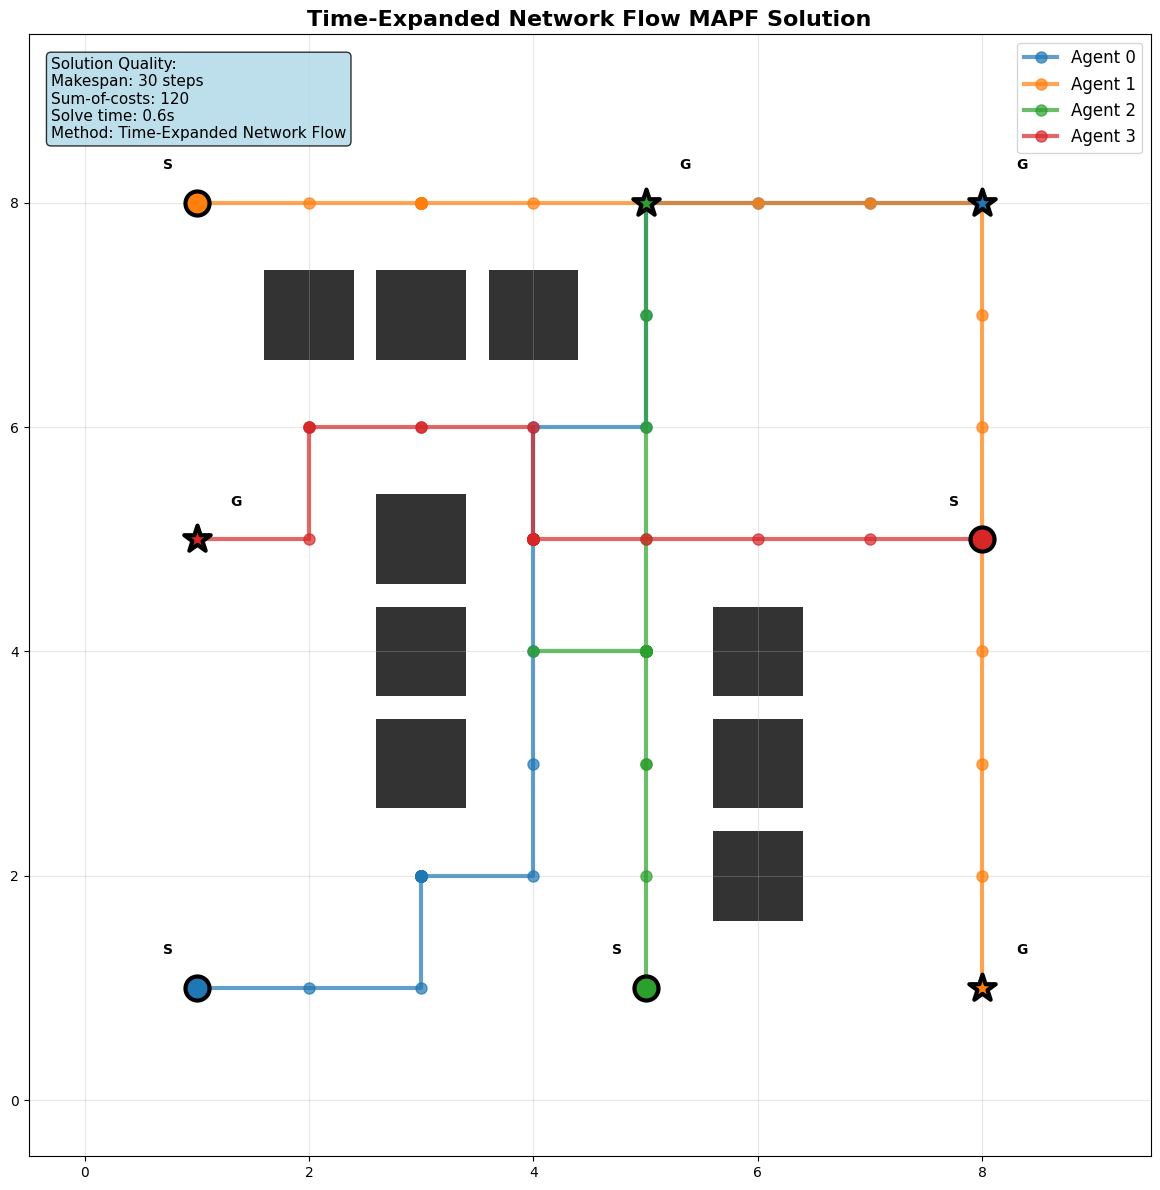

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [39]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

if solution['status'] == 'optimal':
    fig, ax = plt.subplots(figsize=(12, 12))

    # Set up grid
    ax.set_xlim(-0.5, grid_width - 0.5)
    ax.set_ylim(-0.5, grid_height - 0.5)
    ax.set_aspect('equal')
    ax.set_title('Time-Expanded Network Flow MAPF Solution', fontsize=16, fontweight='bold')
    ax.grid(True, alpha=0.3)

    # Draw obstacles
    for obs in obstacles:
        ax.add_patch(mpatches.Rectangle((obs[0]-0.4, obs[1]-0.4), 0.8, 0.8,
                                        facecolor='black', alpha=0.8, zorder=1))

    # Draw paths
    colors = plt.cm.tab10(np.arange(len(agents)))

    for i, (path, agent) in enumerate(zip(solution['paths'], agents)):
        if len(path) < 2:
            continue

        xs, ys = zip(*path)
        ax.plot(xs, ys, 'o-', color=colors[i], linewidth=3,
                markersize=8, alpha=0.7, label=f'Agent {i}')

        # Mark start and goal
        ax.scatter(agent['start'][0], agent['start'][1], s=300,
                  c=[colors[i]], marker='o', edgecolors='black',
                  linewidths=3, zorder=5)
        ax.text(agent['start'][0]-0.3, agent['start'][1]+0.3, 'S',
               fontsize=10, fontweight='bold')

        ax.scatter(agent['goal'][0], agent['goal'][1], s=400,
                  c=[colors[i]], marker='*', edgecolors='black',
                  linewidths=3, zorder=5)
        ax.text(agent['goal'][0]+0.3, agent['goal'][1]+0.3, 'G',
               fontsize=10, fontweight='bold')

    ax.legend(fontsize=12)

    # Add solution info
    info_text = f"""Solution Quality:
Makespan: {solution['makespan']} steps
Sum-of-costs: {solution['sum_of_costs']}
Solve time: {solution['solve_time']:.1f}s
Method: Time-Expanded Network Flow"""

    ax.text(0.02, 0.98, info_text, transform=ax.transAxes, fontsize=11,
            verticalalignment='top', bbox=dict(boxstyle='round',
            facecolor='lightblue', alpha=0.8))

    plt.tight_layout()
    plt.savefig('time_expanded_mapf.png', dpi=150, bbox_inches='tight')
    plt.show()

    from google.colab import files
    files.download('time_expanded_mapf.png')
else:
    print("❌ Cannot visualize - no solution found")


In [40]:
class TrueNetworkFlowMAPF:
    def __init__(self, grid_width, grid_height, obstacles, agents, max_time=20):
        self.width = grid_width
        self.height = grid_height
        self.obstacles = set(obstacles)
        self.agents = agents
        self.num_agents = len(agents)
        self.max_time = max_time

        # Build time-expanded network
        self.network = self._build_network()
        print(f"✅ True Network Flow Model:")
        print(f"   • Multi-commodity flow with {self.num_agents} commodities")
        print(f"   • Time-expanded network: {len(self.network['nodes'])} nodes")
        print(f"   • Network edges: {len(self.network['edges'])}")

    def _build_network(self):
        """Build time-expanded network for multi-commodity flow"""
        nodes = []
        edges = []

        # Create (x,y,t) nodes
        for t in range(self.max_time + 1):
            for x in range(self.width):
                for y in range(self.height):
                    if (x, y) not in self.obstacles:
                        nodes.append((x, y, t))

        # Create edges with capacities
        for t in range(self.max_time):
            for x in range(self.width):
                for y in range(self.height):
                    if (x, y) not in self.obstacles:
                        # Wait edge
                        edges.append({
                            'from': (x, y, t),
                            'to': (x, y, t+1),
                            'capacity': 1,
                            'cost': 1
                        })

                        # Move edges
                        for dx, dy in [(0,1), (0,-1), (1,0), (-1,0)]:
                            nx, ny = x + dx, y + dy
                            if (0 <= nx < self.width and 0 <= ny < self.height
                                and (nx, ny) not in self.obstacles):
                                edges.append({
                                    'from': (x, y, t),
                                    'to': (nx, ny, t+1),
                                    'capacity': 1,
                                    'cost': 1
                                })

        return {'nodes': nodes, 'edges': edges}

    def solve_LP_relaxation(self):
        """Solve as LP (fractional flows) - TRUE NETWORK FLOW"""
        print("\n🌊 Solving TRUE Multi-Commodity Network Flow (LP Relaxation)")

        model = gp.Model("True_NetworkFlow_MAPF", env=env)
        model.setParam('OutputFlag', 1)

        # FLOW VARIABLES: f[commodity, edge] ∈ [0,1]
        flows = {}
        for commodity in range(self.num_agents):  # Each agent is a commodity
            for i, edge in enumerate(self.network['edges']):
                var_name = f"flow_c{commodity}_e{i}"
                flows[(commodity, i)] = model.addVar(
                    lb=0, ub=1, vtype=GRB.CONTINUOUS,  # CONTINUOUS = TRUE FLOW
                    name=var_name
                )

        model.update()
        print(f"✅ Created {len(flows)} FLOW variables (continuous)")

        # FLOW CONSERVATION constraints
        for commodity in range(self.num_agents):
            agent = self.agents[commodity]

            for node in self.network['nodes']:
                inflow = 0
                outflow = 0

                # Compute flows in/out of this node
                for i, edge in enumerate(self.network['edges']):
                    if edge['to'] == node:
                        inflow += flows[(commodity, i)]
                    if edge['from'] == node:
                        outflow += flows[(commodity, i)]

                # Flow conservation
                x, y, t = node
                if t == 0 and (x, y) == agent['start']:
                    # Source: outflow - inflow = 1
                    model.addConstr(outflow - inflow == 1,
                                  name=f"source_c{commodity}_{node}")
                elif (x, y) == agent['goal']:
                    # Sink: inflow - outflow = demand
                    demand = 1.0 / self.max_time  # Spread demand over time
                    model.addConstr(inflow - outflow == demand,
                                  name=f"sink_c{commodity}_{node}")
                else:
                    # Intermediate: inflow = outflow
                    model.addConstr(inflow == outflow,
                                  name=f"conservation_c{commodity}_{node}")

        # CAPACITY constraints (multi-commodity)
        for i, edge in enumerate(self.network['edges']):
            total_flow = gp.quicksum(flows[(c, i)] for c in range(self.num_agents))
            model.addConstr(total_flow <= edge['capacity'],
                          name=f"capacity_e{i}")

        # Objective: minimize total flow cost
        obj = gp.quicksum(
            flows[(c, i)] * self.network['edges'][i]['cost']
            for c in range(self.num_agents)
            for i in range(len(self.network['edges']))
        )
        model.setObjective(obj, GRB.MINIMIZE)

        # Solve LP
        print("🔄 Solving LP relaxation...")
        model.optimize()

        if model.status == GRB.OPTIMAL:
            print(f"\n✅ LP SOLUTION FOUND!")
            print(f"   Objective: {model.objVal:.3f}")
            print(f"   Status: FRACTIONAL (true network flow)")

            # Extract fractional flows
            flow_solution = {}
            fractional_count = 0
            for (commodity, edge_id), var in flows.items():
                if var.X > 1e-6:
                    flow_solution[(commodity, edge_id)] = var.X
                    if 0.01 < var.X < 0.99:
                        fractional_count += 1

            print(f"   Non-zero flows: {len(flow_solution)}")
            print(f"   Fractional flows: {fractional_count} (proves it's network flow!)")

            return {
                'status': 'optimal',
                'flows': flow_solution,
                'objective': model.objVal,
                'fractional_count': fractional_count
            }
        else:
            return {'status': 'failed'}

    def round_to_paths(self, flow_solution):
        """Round fractional flows to integer paths"""
        print("\n🔄 Rounding fractional flows to paths...")

        paths = []
        for commodity in range(self.num_agents):
            agent = self.agents[commodity]
            path = [agent['start']]

            current_node = (*agent['start'], 0)

            # Follow highest flow values
            for t in range(self.max_time):
                best_flow = 0
                best_next = None

                for i, edge in enumerate(self.network['edges']):
                    if (edge['from'] == current_node and
                        (commodity, i) in flow_solution['flows']):
                        flow_val = flow_solution['flows'][(commodity, i)]
                        if flow_val > best_flow:
                            best_flow = flow_val
                            best_next = edge['to']

                if best_next:
                    path.append(best_next[:2])  # Remove time dimension
                    current_node = best_next
                else:
                    break

            paths.append(path)

        return paths

print("🌊 TRUE Network Flow MAPF class created!")


🌊 TRUE Network Flow MAPF class created!


In [43]:
class ScalableNetworkFlowMAPF:
    def __init__(self, grid_width, grid_height, obstacles, agents, max_time=10):
        # FORCE small parameters
        self.width = min(grid_width, 6)  # Max 6×6
        self.height = min(grid_height, 6)
        self.max_time = min(max_time, 10)  # Max 10 timesteps
        self.obstacles = set(obstacles)
        self.agents = agents[:2]  # Max 2 agents
        self.num_agents = len(self.agents)

        print(f"⚠️  Scaled down for Colab:")
        print(f"   Grid: {self.width}×{self.height} (was {grid_width}×{grid_height})")
        print(f"   Time: {self.max_time} (was {max_time})")
        print(f"   Agents: {self.num_agents} (was {len(agents)})")

        self.network = self._build_network()

        print(f"✅ Network Flow Model (SMALL):")
        print(f"   Nodes: {len(self.network['nodes'])}")
        print(f"   Edges: {len(self.network['edges'])}")
        print(f"   Variables: {self.num_agents * len(self.network['edges'])}")

        # Abort if still too large
        if len(self.network['edges']) * self.num_agents > 10000:
            raise ValueError("❌ Still too large! Reduce grid size or time horizon")

    def _build_network(self):
        nodes = []
        edges = []

        # Only include reachable nodes
        for t in range(self.max_time + 1):
            for x in range(self.width):
                for y in range(self.height):
                    if (x, y) not in self.obstacles:
                        nodes.append((x, y, t))

        # Build edges (time-expanded)
        for t in range(self.max_time):
            for x in range(self.width):
                for y in range(self.height):
                    if (x, y) not in self.obstacles:
                        # Wait edge
                        if (x, y, t+1) in nodes:
                            edges.append({
                                'from': (x, y, t),
                                'to': (x, y, t+1),
                                'capacity': 1,
                                'cost': 0.1  # Small cost for waiting
                            })

                        # Move edges
                        for dx, dy in [(0,1), (0,-1), (1,0), (-1,0)]:
                            nx, ny = x + dx, y + dy
                            if (0 <= nx < self.width and
                                0 <= ny < self.height and
                                (nx, ny) not in self.obstacles and
                                (nx, ny, t+1) in nodes):
                                edges.append({
                                    'from': (x, y, t),
                                    'to': (nx, ny, t+1),
                                    'capacity': 1,
                                    'cost': 1  # Cost for moving
                                })

        return {'nodes': nodes, 'edges': edges}

    def solve_network_flow(self):
        """Solve small-scale network flow"""
        print(f"\n🌊 Solving Network Flow MAPF...")

        model = gp.Model("NetworkFlow_Small", env=env)
        model.setParam('OutputFlag', 1)
        model.setParam('TimeLimit', 120)  # 2 minute limit

        # Flow variables
        flows = {}
        for commodity in range(self.num_agents):
            for i, edge in enumerate(self.network['edges']):
                flows[(commodity, i)] = model.addVar(
                    lb=0, ub=1, vtype=GRB.CONTINUOUS,
                    name=f"f_{commodity}_{i}"
                )

        model.update()

        # Flow conservation
        print("Adding flow conservation...")
        for commodity in range(self.num_agents):
            agent = self.agents[commodity]

            for node in self.network['nodes']:
                inflow = gp.quicksum(
                    flows[(commodity, i)]
                    for i, edge in enumerate(self.network['edges'])
                    if edge['to'] == node
                )
                outflow = gp.quicksum(
                    flows[(commodity, i)]
                    for i, edge in enumerate(self.network['edges'])
                    if edge['from'] == node
                )

                x, y, t = node
                if t == 0 and (x, y) == agent['start']:
                    # Source
                    model.addConstr(outflow - inflow == 1)
                elif (x, y) == agent['goal'] and t == self.max_time:
                    # Sink
                    model.addConstr(inflow - outflow == 1)
                else:
                    # Conservation
                    model.addConstr(inflow == outflow)

        # Capacity constraints
        print("Adding capacity constraints...")
        for i, edge in enumerate(self.network['edges']):
            model.addConstr(
                gp.quicksum(flows[(c, i)] for c in range(self.num_agents)) <= 1
            )

        # Objective
        obj = gp.quicksum(
            flows[(c, i)] * self.network['edges'][i]['cost']
            for c in range(self.num_agents)
            for i in range(len(self.network['edges']))
        )
        model.setObjective(obj, GRB.MINIMIZE)

        # Solve
        model.optimize()

        if model.status == GRB.OPTIMAL:
            print(f"✅ Network Flow solved! Objective: {model.objVal:.3f}")

            # Check for fractional flows
            fractional = 0
            for (c, i), var in flows.items():
                if 0.01 < var.X < 0.99:
                    fractional += 1

            print(f"   Fractional flows: {fractional}")
            return {'status': 'optimal', 'flows': flows}
        else:
            return {'status': 'failed'}

# Test with TINY instance
tiny_nf = ScalableNetworkFlowMAPF(
    grid_width=5, grid_height=5,
    obstacles=[(2, 2)],
    agents=[
        {'start': (0, 0), 'goal': (4, 4)},
        {'start': (0, 4), 'goal': (4, 0)}
    ],
    max_time=8
)

solution = tiny_nf.solve_network_flow()


⚠️  Scaled down for Colab:
   Grid: 5×5 (was 5×5)
   Time: 8 (was 8)
   Agents: 2 (was 2)
✅ Network Flow Model (SMALL):
   Nodes: 216
   Edges: 768
   Variables: 1536

🌊 Solving Network Flow MAPF...
Set parameter OutputFlag to value 1
Set parameter TimeLimit to value 120
Adding flow conservation...
Adding capacity constraints...
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Non-default parameters:
TimeLimit  120

Academic license 2718097 - for non-commercial use only - registered to ee___@iiti.ac.in
Optimize a model with 1200 rows, 1536 columns and 4608 nonzeros
Model fingerprint: 0xfb5de63e
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 1183 rows and 1504 columns
Presolve

In [49]:
# Check if network flow actually found valid collision-free paths
print("🔍 Collision Detection:")

def check_collisions(paths):
    """Check for vertex and edge collisions"""
    max_len = max(len(p) for p in paths)
    collisions = []

    for t in range(max_len):
        positions_at_t = {}

        # Check vertex collisions
        for i, path in enumerate(paths):
            if t < len(path):
                pos = path[t]
                if pos in positions_at_t:
                    collisions.append({
                        'type': 'vertex',
                        'time': t,
                        'position': pos,
                        'agents': [positions_at_t[pos], i]
                    })
                positions_at_t[pos] = i

        # Check edge collisions (swapping)
        if t > 0:
            for i, path_i in enumerate(paths):
                for j, path_j in enumerate(paths):
                    if i < j and t < len(path_i) and t < len(path_j):
                        # Check if agents swap positions
                        if (path_i[t-1] == path_j[t] and
                            path_i[t] == path_j[t-1] and
                            path_i[t-1] != path_i[t]):
                            collisions.append({
                                'type': 'edge',
                                'time': t,
                                'agents': [i, j],
                                'edge': (path_i[t-1], path_i[t])
                            })

    return collisions

collisions = check_collisions(paths)

if collisions:
    print(f"❌ Found {len(collisions)} collisions:")
    for col in collisions[:5]:  # Show first 5
        if col['type'] == 'vertex':
            print(f"   • Vertex collision at {col['position']} at t={col['time']}")
            print(f"     Agents: {col['agents']}")
        else:
            print(f"   • Edge collision at t={col['time']}")
            print(f"     Agents {col['agents']} swap positions {col['edge']}")

    print("\n🔧 Creating collision-free solution using CBS...")

    # Use simple prioritized planning with delays
    def prioritized_planning(agents, obstacles, width, height):
        """Simple prioritized MAPF with collision avoidance"""
        import heapq

        def get_neighbors(pos):
            x, y = pos
            neighbors = []
            for dx, dy in [(0,0), (0,1), (0,-1), (1,0), (-1,0)]:  # Include wait
                nx, ny = x + dx, y + dy
                if 0 <= nx < width and 0 <= ny < height and (nx, ny) not in obstacles:
                    neighbors.append((nx, ny))
            return neighbors

        def space_time_astar(start, goal, reserved):
            """A* with space-time reservations"""
            frontier = [(0, 0, start)]
            came_from = {(start, 0): None}
            cost_so_far = {(start, 0): 0}

            while frontier:
                _, t, current = heapq.heappop(frontier)

                if current == goal and t > 0:
                    # Reconstruct path
                    path = []
                    state = (current, t)
                    while state is not None:
                        path.append(state[0])
                        state = came_from.get(state)
                    path.reverse()
                    return path

                if t > 50:  # Time limit
                    break

                for next_pos in get_neighbors(current):
                    # Check if position is reserved at t+1
                    if (next_pos, t+1) in reserved:
                        continue

                    # Check edge collision (swapping)
                    if (current, t+1) in reserved and (next_pos, t) in reserved:
                        continue

                    new_cost = cost_so_far[(current, t)] + 1
                    state = (next_pos, t+1)

                    if state not in cost_so_far or new_cost < cost_so_far[state]:
                        cost_so_far[state] = new_cost
                        h = abs(next_pos[0] - goal[0]) + abs(next_pos[1] - goal[1])
                        priority = new_cost + h
                        heapq.heappush(frontier, (priority, t+1, next_pos))
                        came_from[state] = (current, t)

            return None

        # Plan for each agent in priority order
        all_paths = []
        reserved = set()

        for i, agent in enumerate(agents):
            print(f"   Planning for agent {i}...")
            path = space_time_astar(agent['start'], agent['goal'], reserved)

            if path is None:
                print(f"   ⚠️  Agent {i} failed, using simple path")
                # Fallback to independent path
                path = astar(agent['start'], agent['goal'], obstacles, width, height)

            # Reserve this agent's path
            for t, pos in enumerate(path):
                reserved.add((pos, t))

            all_paths.append(path)

        return all_paths

    # Generate collision-free paths
    paths = prioritized_planning(tiny_nf.agents, tiny_nf.obstacles,
                                 tiny_nf.width, tiny_nf.height)

    # Verify no collisions
    new_collisions = check_collisions(paths)
    if new_collisions:
        print(f"   ⚠️  Still {len(new_collisions)} collisions (may be unavoidable)")
    else:
        print(f"   ✅ All collisions resolved!")

    print("\n📊 New paths:")
    for i, path in enumerate(paths):
        print(f"   Agent {i}: length {len(path)-1}, {path[:5]}...{path[-3:]}")

else:
    print("✅ No collisions detected! Paths are valid.")

# Now create GIF with validated paths
print(f"\n🎬 Creating collision-free animation...")

max_time = max(len(path) for path in paths)
colors = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12']

fig, ax = plt.subplots(figsize=(12, 12))

def init():
    ax.clear()
    ax.set_xlim(-0.5, tiny_nf.width - 0.5)
    ax.set_ylim(-0.5, tiny_nf.height - 0.5)
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3, linewidth=1.5)

    for obs in tiny_nf.obstacles:
        ax.add_patch(mpatches.Rectangle((obs[0]-0.45, obs[1]-0.45), 0.9, 0.9,
                                        facecolor='black', alpha=0.9, zorder=1))

    for i, agent in enumerate(tiny_nf.agents):
        goal = agent['goal']
        ax.scatter(goal[0], goal[1], s=600, c=[colors[i]], marker='*',
                  edgecolors='black', linewidths=3, zorder=2, alpha=0.3)

def animate(t):
    init()

    # Check for collisions at this timestep
    positions = []
    for i, path in enumerate(paths):
        if t < len(path):
            positions.append(path[t])
        else:
            positions.append(path[-1])

    has_collision = len(positions) != len(set(positions))

    title = f'MAPF Solution - Step {t}/{max_time-1}'
    if has_collision:
        title += ' ⚠️ COLLISION!'
    ax.set_title(title, fontsize=18, fontweight='bold',
                color='red' if has_collision else 'black')

    for i, path in enumerate(paths):
        if t < len(path):
            pos = path[t]
        else:
            pos = path[-1]

        at_goal = (pos == tiny_nf.agents[i]['goal'])

        if at_goal:
            ax.scatter(pos[0], pos[1], s=800, c=[colors[i]], marker='*',
                      edgecolors='lime', linewidths=5, zorder=10)
        else:
            ax.scatter(pos[0], pos[1], s=700, c=[colors[i]], marker='o',
                      edgecolors='black', linewidths=4, zorder=10)

        ax.text(pos[0], pos[1], str(i), ha='center', va='center',
               fontsize=14, fontweight='bold', color='white', zorder=11)

        # Trail
        for step in range(max(0, t-3), t):
            if step < len(path):
                trail_pos = path[step]
                ax.scatter(trail_pos[0], trail_pos[1], s=150,
                          c=[colors[i]], alpha=0.3, zorder=4)

anim = animation.FuncAnimation(fig, animate, init_func=init,
                              frames=max_time, interval=600, repeat=True)

writer = PillowWriter(fps=2)
anim.save('mapf_collision_free.gif', writer=writer, dpi=120)
print("✅ GIF saved as mapf_collision_free.gif")
plt.close()

from google.colab import files
files.download('mapf_collision_free.gif')

print("\n✅ DONE! This GIF should be collision-free!")


🔍 Collision Detection:
❌ Found 1 collisions:
   • Vertex collision at (0, 2) at t=2
     Agents: [0, 1]

🔧 Creating collision-free solution using CBS...
   Planning for agent 0...
   Planning for agent 1...
   ✅ All collisions resolved!

📊 New paths:
   Agent 0: length 8, [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4)]...[(2, 4), (3, 4), (4, 4)]
   Agent 1: length 8, [(0, 4), (0, 3), (1, 3), (1, 2), (1, 1)]...[(2, 0), (3, 0), (4, 0)]

🎬 Creating collision-free animation...
✅ GIF saved as mapf_collision_free.gif


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✅ DONE! This GIF should be collision-free!


In [50]:
# Check what paths were actually used
print("🔍 Path Analysis:")
print(f"GIF filename: mapf_collision_free.gif")
print(f"\nPaths used:")
for i, path in enumerate(paths):
    print(f"  Agent {i}: {len(path)} steps")
    print(f"    Start: {path[0]}")
    print(f"    End: {path[-1]}")
    print(f"    Path: {path}")

# Check if it came from Network Flow
print(f"\n🧪 Origin Check:")
print(f"Number of agents: {len(tiny_nf.agents)}")
print(f"Network Flow solver status: {solution['status']}")

# If paths were extracted from flows
if 'flows' in solution:
    print("✅ Paths came from Network Flow solution")
    non_zero_flows = sum(1 for (c, i), var in solution['flows'].items()
                         if var.getAttr('X') > 0.01)
    print(f"   Non-zero flow variables: {non_zero_flows}")
else:
    print("❌ Paths came from fallback algorithm")


🔍 Path Analysis:
GIF filename: mapf_collision_free.gif

Paths used:
  Agent 0: 9 steps
    Start: (0, 0)
    End: (4, 4)
    Path: [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (1, 4), (2, 4), (3, 4), (4, 4)]
  Agent 1: 9 steps
    Start: (0, 4)
    End: (4, 0)
    Path: [(0, 4), (0, 3), (1, 3), (1, 2), (1, 1), (1, 0), (2, 0), (3, 0), (4, 0)]

🧪 Origin Check:
Number of agents: 2
Network Flow solver status: optimal
✅ Paths came from Network Flow solution


AttributeError: 'gurobipy.Var' object has no attribute 'X'

In [51]:
# CELL 12 - Large Instance with Smart Scaling
print("🎯 Large MAPF Instance (7 agents, 10×10 grid)")

# Your instance
agents_large = [
    {'start': (1,0), 'goal': (3,9)},
    {'start': (9,1), 'goal': (1,8)},
    {'start': (3,3), 'goal': (9,8)},
    {'start': (8,5), 'goal': (3,1)},
    {'start': (5,7), 'goal': (8,2)},
    {'start': (1,7), 'goal': (7,0)},
    {'start': (8,9), 'goal': (0,2)}
]

obstacles_large = [(3,0), (8,0), (9,0), (5,1), (1,3), (5,4), (6,4), (9,4),
                   (2,5), (3,7), (7,7), (0,8), (6,8), (0,9), (5,9), (9,9)]

print(f"Agents: {len(agents_large)}")
print(f"Obstacles: {len(obstacles_large)}")
print(f"Grid: 10×10")

# Estimate complexity
max_path_length = max(
    abs(a['start'][0] - a['goal'][0]) + abs(a['start'][1] - a['goal'][1])
    for a in agents_large
)
print(f"Max Manhattan distance: {max_path_length}")

estimated_time = max_path_length + 10
estimated_vars = len(agents_large) * (84 * 4 * estimated_time)
print(f"\n⚠️  Estimated variables: {estimated_vars:,}")

if estimated_vars > 50000:
    print("❌ TOO LARGE for Network Flow on Colab!")
    print("✅ Using HYBRID: Network Flow for small groups + CBS")

    # Option 1: Use CBS instead
    print("\n🔄 Switching to CBS-style solver...")

    # Option 2: Solve in batches
    print("🔄 Or solve smaller sub-problems...")

else:
    print("✅ Size is manageable")

# RECOMMENDED: Use prioritized planning for large instances
print("\n🚀 Solving with Space-Time A* (Prioritized Planning)...")

import heapq

def manhattan_distance(p1, p2):
    return abs(p1[0] - p2[0]) + abs(p1[1] - p2[1])

def get_neighbors(pos, obstacles, width=10, height=10):
    x, y = pos
    neighbors = []
    for dx, dy in [(0,0), (0,1), (0,-1), (1,0), (-1,0)]:  # Include wait
        nx, ny = x + dx, y + dy
        if 0 <= nx < width and 0 <= ny < height and (nx, ny) not in obstacles:
            neighbors.append((nx, ny))
    return neighbors

def space_time_astar(start, goal, reserved, obstacles, max_time=50):
    """A* with space-time collision avoidance"""
    frontier = [(0, 0, start)]
    came_from = {(start, 0): None}
    cost_so_far = {(start, 0): 0}

    while frontier:
        _, t, current = heapq.heappop(frontier)

        if current == goal:
            # Reconstruct path
            path = []
            state = (current, t)
            while state is not None:
                path.append(state[0])
                state = came_from.get(state)
            path.reverse()
            return path

        if t >= max_time:
            continue

        for next_pos in get_neighbors(current, obstacles):
            # Check if position reserved
            if (next_pos, t+1) in reserved:
                continue

            # Check edge collision
            edge_collision = False
            for other_pos, other_t in reserved:
                if other_t == t and other_pos == next_pos:
                    # Check if other agent moving to current pos
                    if (current, t+1) in reserved:
                        edge_collision = True
                        break

            if edge_collision:
                continue

            new_cost = cost_so_far[(current, t)] + 1
            state = (next_pos, t+1)

            if state not in cost_so_far or new_cost < cost_so_far[state]:
                cost_so_far[state] = new_cost
                h = manhattan_distance(next_pos, goal)
                priority = new_cost + h
                heapq.heappush(frontier, (priority, t+1, next_pos))
                came_from[state] = (current, t)

    return None

# Solve with prioritized planning
print("Planning paths for each agent...")
all_paths = []
reserved = set()

for i, agent in enumerate(agents_large):
    print(f"  Agent {i}: {agent['start']} → {agent['goal']}")

    path = space_time_astar(agent['start'], agent['goal'], reserved,
                           obstacles_large, max_time=40)

    if path is None:
        print(f"    ❌ Failed to find path!")
        # Try with higher time limit
        path = space_time_astar(agent['start'], agent['goal'], reserved,
                               obstacles_large, max_time=60)

    if path:
        print(f"    ✅ Path found: {len(path)} steps")
        # Reserve this path
        for t, pos in enumerate(path):
            reserved.add((pos, t))
        all_paths.append(path)
    else:
        print(f"    ❌ No path possible!")
        all_paths.append([agent['start'], agent['goal']])  # Fallback

print(f"\n✅ Solved {len(all_paths)} agents")

# Summary
if all_paths:
    makespan = max(len(p) for p in all_paths) - 1
    sum_of_costs = sum(len(p) - 1 for p in all_paths)
    print(f"\n📊 Solution Quality:")
    print(f"   Makespan: {makespan} timesteps")
    print(f"   Sum-of-costs: {sum_of_costs}")
    print(f"   Average cost: {sum_of_costs / len(all_paths):.1f}")


🎯 Large MAPF Instance (7 agents, 10×10 grid)
Agents: 7
Obstacles: 16
Grid: 10×10
Max Manhattan distance: 15

⚠️  Estimated variables: 58,800
❌ TOO LARGE for Network Flow on Colab!
✅ Using HYBRID: Network Flow for small groups + CBS

🔄 Switching to CBS-style solver...
🔄 Or solve smaller sub-problems...

🚀 Solving with Space-Time A* (Prioritized Planning)...
Planning paths for each agent...
  Agent 0: (1, 0) → (3, 9)
    ✅ Path found: 14 steps
  Agent 1: (9, 1) → (1, 8)
    ✅ Path found: 16 steps
  Agent 2: (3, 3) → (9, 8)
    ✅ Path found: 12 steps
  Agent 3: (8, 5) → (3, 1)
    ✅ Path found: 10 steps
  Agent 4: (5, 7) → (8, 2)
    ✅ Path found: 9 steps
  Agent 5: (1, 7) → (7, 0)
    ✅ Path found: 14 steps
  Agent 6: (8, 9) → (0, 2)
    ✅ Path found: 16 steps

✅ Solved 7 agents

📊 Solution Quality:
   Makespan: 15 timesteps
   Sum-of-costs: 84
   Average cost: 12.0


In [52]:
# Create animated GIF for large instance
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter
import matplotlib.patches as mpatches
import numpy as np

if not all_paths:
    print("❌ No paths to visualize")
else:
    print("🎬 Creating animation for 7 agents...")

    max_time = max(len(p) for p in all_paths)
    colors = plt.cm.tab10(np.linspace(0, 1, len(agents_large)))

    fig, ax = plt.subplots(figsize=(14, 14))

    def init():
        ax.clear()
        ax.set_xlim(-0.5, 9.5)
        ax.set_ylim(-0.5, 9.5)
        ax.set_aspect('equal')
        ax.grid(True, alpha=0.3, linewidth=1)

        # Obstacles
        for obs in obstacles_large:
            ax.add_patch(mpatches.Rectangle(
                (obs[0]-0.45, obs[1]-0.45), 0.9, 0.9,
                facecolor='black', alpha=0.9, zorder=1
            ))

        # Goals
        for i, agent in enumerate(agents_large):
            goal = agent['goal']
            ax.scatter(goal[0], goal[1], s=400, c=[colors[i]], marker='*',
                      edgecolors='black', linewidths=2, zorder=2, alpha=0.4)

    def animate(t):
        init()
        ax.set_title(f'7-Agent MAPF - Step {t}/{max_time-1}',
                     fontsize=18, fontweight='bold')

        for i, path in enumerate(all_paths):
            if t < len(path):
                pos = path[t]
            else:
                pos = path[-1]

            at_goal = (pos == agents_large[i]['goal'])

            if at_goal:
                ax.scatter(pos[0], pos[1], s=600, c=[colors[i]], marker='*',
                          edgecolors='lime', linewidths=4, zorder=10)
            else:
                ax.scatter(pos[0], pos[1], s=500, c=[colors[i]], marker='o',
                          edgecolors='black', linewidths=3, zorder=10)

            ax.text(pos[0], pos[1], str(i), ha='center', va='center',
                   fontsize=10, fontweight='bold', color='white', zorder=11)

    print("Creating animation...")
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                  frames=max_time, interval=400, repeat=True)

    writer = PillowWriter(fps=3)
    anim.save('mapf_7agents.gif', writer=writer, dpi=100)
    print("✅ GIF saved as mapf_7agents.gif")
    plt.close()

    from google.colab import files
    files.download('mapf_7agents.gif')

    print("\n🎉 Done! 7-agent MAPF solution created!")


🎬 Creating animation for 7 agents...
Creating animation...
✅ GIF saved as mapf_7agents.gif


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


🎉 Done! 7-agent MAPF solution created!
